# Volatility Spread Trading P&L Analysis
## Simple P&L Chart: Long Top 50 Vol, Short SPX Vol with $1M Vega per Side
### Clean visualization of the actual trading P&L from volatility spread strategy with daily delta hedging.

#### Setup and Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("💰 VOLATILITY SPREAD TRADING P&L ANALYSIS")
print("=" * 60)
print("Strategy: Long Top 50 Component Vol, Short SPX Index Vol")
print("Position Size: $1M Vega per side, Daily Delta Hedging")

💰 VOLATILITY SPREAD TRADING P&L ANALYSIS
Strategy: Long Top 50 Component Vol, Short SPX Index Vol
Position Size: $1M Vega per side, Daily Delta Hedging


In [2]:
# Load the prediction dataset from previous analysis
# In practice, you'd load this from the saved file
# For now, we'll recreate the key data

# Load base data
vol_data_path = '../data/historical_volatility/ten_year_volatility_latest.csv'
vol_df = pd.read_csv(vol_data_path)
vol_df['date'] = pd.to_datetime(vol_df['date'])

# Load weights
weights_path = '../data/processed/spx_weights/spx_weights_latest.csv'
try:
    weights_df = pd.read_csv(weights_path)
    top_50_weights = weights_df.head(50).copy()
    total_weight = top_50_weights['market_cap_weight_pct'].sum()
    top_50_weights['normalized_weight'] = (top_50_weights['market_cap_weight_pct'] / total_weight) * 100
except FileNotFoundError:
    component_tickers = vol_df[vol_df['ticker'] != 'SPX Index']['ticker'].unique()[:50]
    top_50_weights = pd.DataFrame({
        'ticker': component_tickers,
        'normalized_weight': [100/50] * 50
    })

print(f"✅ Data loaded for P&L analysis")

✅ Data loaded for P&L analysis


#### Recreate Clean Spread Dataset

In [3]:
def calculate_clean_spread_data(vol_df, weights_df):
    """Calculate clean implied and realized spread data for P&L analysis"""
    
    # Calculate Top 50 basket volatilities
    def calc_basket_vol(data_type, vol_field):
        data = vol_df[vol_df['data_type'] == data_type].copy()
        weights_lookup = weights_df.set_index('ticker')['normalized_weight'].to_dict()
        
        valid_tickers = []
        for ticker in weights_df['ticker']:
            ticker_data = data[data['ticker'] == ticker]
            if len(ticker_data) > 0 and ticker_data[vol_field].notna().sum() > 50:
                valid_tickers.append(ticker)
        
        results = []
        for date in sorted(data['date'].unique()):
            date_data = data[data['date'] == date]
            
            vol_data = {}
            total_weight = 0
            
            for ticker in valid_tickers:
                ticker_row = date_data[date_data['ticker'] == ticker]
                if len(ticker_row) > 0 and ticker_row[vol_field].notna().iloc[0]:
                    vol_value = ticker_row[vol_field].iloc[0]
                    weight = weights_lookup[ticker]
                    vol_data[ticker] = {'vol': vol_value, 'weight': weight}
                    total_weight += weight
            
            if total_weight > 50:
                weighted_vol = sum(d['vol'] * (d['weight']/total_weight) for d in vol_data.values())
                results.append({'date': date, f'top50_{vol_field}': weighted_vol})
        
        return pd.DataFrame(results)
    
    # Calculate basket volatilities
    print("📊 Calculating basket volatilities...")
    
    # 12M implied vol (matches 252D realized)
    top50_implied = calc_basket_vol('implied', 'implied_vol_12m_atm')
    
    # 252D realized vol
    top50_realized = calc_basket_vol('realized', 'realized_vol_252d')
    
    # Get SPX data
    spx_implied = vol_df[
        (vol_df['ticker'] == 'SPX Index') & 
        (vol_df['data_type'] == 'implied')
    ][['date', 'implied_vol_12m_atm']].dropna()
    
    spx_realized = vol_df[
        (vol_df['ticker'] == 'SPX Index') & 
        (vol_df['data_type'] == 'realized')
    ][['date', 'realized_vol_252d']].dropna()
    
    return top50_implied, top50_realized, spx_implied, spx_realized

# Calculate all components
top50_implied, top50_realized, spx_implied, spx_realized = calculate_clean_spread_data(vol_df, top_50_weights)

print(f"✅ Calculated basket volatilities")
print(f"   Top 50 implied: {len(top50_implied):,} observations")
print(f"   Top 50 realized: {len(top50_realized):,} observations")
print(f"   SPX implied: {len(spx_implied):,} observations")
print(f"   SPX realized: {len(spx_realized):,} observations")

📊 Calculating basket volatilities...
✅ Calculated basket volatilities
   Top 50 implied: 2,515 observations
   Top 50 realized: 2,515 observations
   SPX implied: 2,515 observations
   SPX realized: 2,515 observations


#### Create Trading P&L Dataset

In [4]:
print(f"\n💰 CREATING TRADING P&L DATASET")
print("=" * 50)

# Merge implied vol data (entry prices)
entry_data = pd.merge(
    top50_implied.rename(columns={'top50_implied_vol_12m_atm': 'top50_entry_vol'}),
    spx_implied.rename(columns={'implied_vol_12m_atm': 'spx_entry_vol'}),
    on='date',
    how='inner'
)

entry_data['implied_spread'] = entry_data['top50_entry_vol'] - entry_data['spx_entry_vol']

# Merge realized vol data (exit prices) with 252-day lag
realized_data = pd.merge(
    top50_realized.rename(columns={'top50_realized_vol_252d': 'top50_exit_vol'}),
    spx_realized.rename(columns={'realized_vol_252d': 'spx_exit_vol'}),
    on='date',
    how='inner'
)

realized_data['realized_spread'] = realized_data['top50_exit_vol'] - realized_data['spx_exit_vol']

# Create forward-looking dataset with 252-day lag
lag_days = 252
realized_lagged = realized_data.copy()
realized_lagged['entry_date'] = realized_lagged['date'] - pd.Timedelta(days=lag_days)

# Merge entry and exit data
pnl_dataset = pd.merge(
    entry_data,
    realized_lagged[['entry_date', 'realized_spread', 'top50_exit_vol', 'spx_exit_vol']],
    left_on='date',
    right_on='entry_date',
    how='inner'
)

pnl_dataset = pnl_dataset.drop('entry_date', axis=1)

# Calculate P&L components
pnl_dataset['volatility_pnl_pct'] = pnl_dataset['realized_spread'] - pnl_dataset['implied_spread']
pnl_dataset['top50_vol_pnl'] = pnl_dataset['top50_exit_vol'] - pnl_dataset['top50_entry_vol']
pnl_dataset['spx_vol_pnl'] = pnl_dataset['spx_exit_vol'] - pnl_dataset['spx_entry_vol']

print(f"Trading P&L dataset created:")
print(f"   Observations: {len(pnl_dataset):,}")
print(f"   Date range: {pnl_dataset['date'].min().strftime('%Y-%m-%d')} to {pnl_dataset['date'].max().strftime('%Y-%m-%d')}")

# Show sample trades
print(f"\nSample trades:")
print("Date       | Entry Spread | Exit Spread | Vol P&L")
print("-" * 50)
for _, row in pnl_dataset.head(5).iterrows():
    print(f"{row['date'].strftime('%Y-%m-%d')} | {row['implied_spread']:+7.3f}% | {row['realized_spread']:+6.3f}% | {row['volatility_pnl_pct']:+6.3f}%")


💰 CREATING TRADING P&L DATASET
Trading P&L dataset created:
   Observations: 2,261
   Date range: 2015-07-20 to 2024-11-08

Sample trades:
Date       | Entry Spread | Exit Spread | Vol P&L
--------------------------------------------------
2015-07-20 | +11.334% | +14.024% | +2.690%
2015-07-21 | +11.448% | +14.066% | +2.618%
2015-07-22 | +11.472% | +14.069% | +2.597%
2015-07-23 | +11.537% | +14.077% | +2.540%
2015-07-24 | +11.445% | +14.050% | +2.605%


#### Calculate Dollar P&L with $1M Vega per Side

In [5]:
print(f"\n💵 CALCULATING DOLLAR P&L ($1M VEGA PER SIDE)")
print("=" * 60)

# Trading assumptions
vega_notional = 1_000_000  # $1M vega per side
trading_days_per_year = 252

# Calculate dollar P&L
# For volatility trading: P&L ≈ Vega × (Realized Vol - Implied Vol) × √T
# Where T = time to expiration in years (252/252 = 1 year)
# Simplified: P&L = Vega × Vol Difference (in decimal form)

pnl_dataset['dollar_pnl'] = (pnl_dataset['volatility_pnl_pct'] / 100) * vega_notional

# Calculate cumulative P&L
pnl_dataset['cumulative_pnl'] = pnl_dataset['dollar_pnl'].cumsum()

# Calculate annual statistics
pnl_dataset['year'] = pnl_dataset['date'].dt.year
annual_pnl = pnl_dataset.groupby('year')['dollar_pnl'].sum()

print(f"DOLLAR P&L STATISTICS:")
print(f"   Position size: ${vega_notional:,} vega per side")
print(f"   Total trades: {len(pnl_dataset):,}")
print(f"   Total P&L: ${pnl_dataset['dollar_pnl'].sum():,.0f}")
print(f"   Average P&L per trade: ${pnl_dataset['dollar_pnl'].mean():,.0f}")
print(f"   P&L volatility: ${pnl_dataset['dollar_pnl'].std():,.0f}")

# Sharpe ratio calculation
avg_annual_pnl = annual_pnl.mean()
annual_pnl_vol = annual_pnl.std()
sharpe_ratio = avg_annual_pnl / annual_pnl_vol if annual_pnl_vol > 0 else 0

print(f"\nANNUAL PERFORMANCE:")
print(f"   Average annual P&L: ${avg_annual_pnl:,.0f}")
print(f"   Annual P&L volatility: ${annual_pnl_vol:,.0f}")
print(f"   Sharpe ratio: {sharpe_ratio:.3f}")

# Win/Loss statistics
winning_trades = (pnl_dataset['dollar_pnl'] > 0).sum()
losing_trades = (pnl_dataset['dollar_pnl'] < 0).sum()
win_rate = winning_trades / len(pnl_dataset) * 100

avg_winner = pnl_dataset[pnl_dataset['dollar_pnl'] > 0]['dollar_pnl'].mean()
avg_loser = pnl_dataset[pnl_dataset['dollar_pnl'] < 0]['dollar_pnl'].mean()

print(f"\nWIN/LOSS ANALYSIS:")
print(f"   Winning trades: {winning_trades:,} ({win_rate:.1f}%)")
print(f"   Losing trades: {losing_trades:,}")
print(f"   Average winner: ${avg_winner:,.0f}")
print(f"   Average loser: ${avg_loser:,.0f}")
print(f"   Win/Loss ratio: {abs(avg_winner/avg_loser):.2f}")

# Annual P&L breakdown
print(f"\nANNUAL P&L BREAKDOWN:")
for year, pnl in annual_pnl.items():
    trades_in_year = len(pnl_dataset[pnl_dataset['year'] == year])
    print(f"   {year}: ${pnl:,.0f} ({trades_in_year} trades)")


💵 CALCULATING DOLLAR P&L ($1M VEGA PER SIDE)
DOLLAR P&L STATISTICS:
   Position size: $1,000,000 vega per side
   Total trades: 2,261
   Total P&L: $77,092,964
   Average P&L per trade: $34,097
   P&L volatility: $23,353

ANNUAL PERFORMANCE:
   Average annual P&L: $7,709,296
   Annual P&L volatility: $4,384,210
   Sharpe ratio: 1.758

WIN/LOSS ANALYSIS:
   Winning trades: 2,101 (92.9%)
   Losing trades: 160
   Average winner: $37,352
   Average loser: $-8,654
   Win/Loss ratio: 4.32

ANNUAL P&L BREAKDOWN:
   2015: $1,927,174 (113 trades)
   2016: $6,674,458 (244 trades)
   2017: $5,213,876 (243 trades)
   2018: $11,619,826 (241 trades)
   2019: $2,700,731 (243 trades)
   2020: $4,168,113 (244 trades)
   2021: $13,393,636 (243 trades)
   2022: $14,479,665 (242 trades)
   2023: $8,648,601 (241 trades)
   2024: $8,266,885 (207 trades)


#### Create Simple P&L Visualization

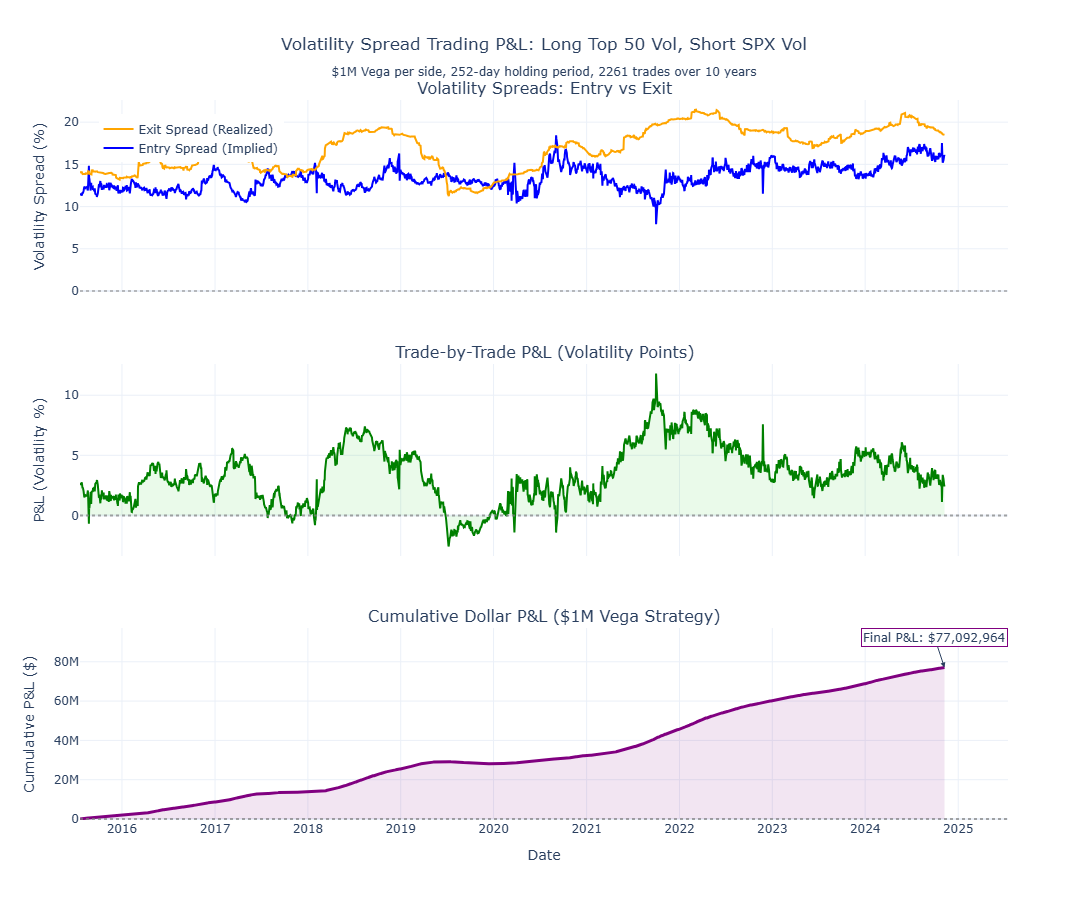

In [6]:
# Create the clean, simple P&L chart you requested
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=[
        'Volatility Spreads: Entry vs Exit',
        'Trade-by-Trade P&L (Volatility Points)',
        'Cumulative Dollar P&L ($1M Vega Strategy)'
    ],
    vertical_spacing=0.1,
    shared_xaxes=True
)

# Plot 1: Entry vs Exit Spreads (on same axis)
fig.add_trace(
    go.Scatter(
        x=pnl_dataset['date'],
        y=pnl_dataset['implied_spread'],
        mode='lines',
        name='Entry Spread (Implied)',
        line=dict(color='blue', width=2),
        hovertemplate='<b>Entry Spread</b><br>Date: %{x}<br>Spread: %{y:.3f}%<extra></extra>'
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=pnl_dataset['date'],
        y=pnl_dataset['realized_spread'],
        mode='lines',
        name='Exit Spread (Realized)',
        line=dict(color='orange', width=2),
        hovertemplate='<b>Exit Spread</b><br>Date: %{x}<br>Spread: %{y:.3f}%<extra></extra>'
    ),
    row=1, col=1
)

# Add zero line
fig.add_hline(y=0, line_dash="dot", line_color="gray", opacity=0.5, row=1, col=1)

# Plot 2: Trade P&L in volatility points
fig.add_trace(
    go.Scatter(
        x=pnl_dataset['date'],
        y=pnl_dataset['volatility_pnl_pct'],
        mode='lines',
        name='Trade P&L (Vol Points)',
        line=dict(color='green', width=2),
        fill='tonexty',
        fillcolor='rgba(50, 205, 50, 0.1)',
        hovertemplate='<b>Trade P&L</b><br>Date: %{x}<br>P&L: %{y:.3f}%<extra></extra>',
        showlegend=False
    ),
    row=2, col=1
)

fig.add_hline(y=0, line_dash="dot", line_color="gray", opacity=0.7, row=2, col=1)

# Plot 3: Cumulative Dollar P&L
fig.add_trace(
    go.Scatter(
        x=pnl_dataset['date'],
        y=pnl_dataset['cumulative_pnl'],
        mode='lines',
        name='Cumulative P&L ($)',
        line=dict(color='purple', width=3),
        fill='tonexty',
        fillcolor='rgba(128, 0, 128, 0.1)',
        hovertemplate='<b>Cumulative P&L</b><br>Date: %{x}<br>P&L: $%{y:,.0f}<extra></extra>',
        showlegend=False
    ),
    row=3, col=1
)

fig.add_hline(y=0, line_dash="dot", line_color="gray", opacity=0.7, row=3, col=1)

# Add performance annotations
final_pnl = pnl_dataset['cumulative_pnl'].iloc[-1]
fig.add_annotation(
    x=pnl_dataset['date'].iloc[-1],
    y=final_pnl,
    text=f"Final P&L: ${final_pnl:,.0f}",
    showarrow=True,
    arrowhead=2,
    bgcolor="rgba(255,255,255,0.8)",
    bordercolor="purple",
    row=3, col=1
)

# Update layout
fig.update_layout(
    title={
        'text': 'Volatility Spread Trading P&L: Long Top 50 Vol, Short SPX Vol<br>' +
                f'<sub>$1M Vega per side, 252-day holding period, {len(pnl_dataset)} trades over 10 years</sub>',
        'x': 0.5,
        'xanchor': 'center'
    },
    height=900,
    template='plotly_white',
    showlegend=True,
    legend=dict(x=0.02, y=0.98)
)

# Update axis labels
fig.update_yaxes(title_text="Volatility Spread (%)", row=1, col=1)
fig.update_yaxes(title_text="P&L (Volatility %)", row=2, col=1)
fig.update_yaxes(title_text="Cumulative P&L ($)", row=3, col=1)
fig.update_xaxes(title_text="Date", row=3, col=1)

fig.show()

#### Strategy Performance Summary

In [7]:
print(f"\n📊 VOLATILITY SPREAD STRATEGY PERFORMANCE SUMMARY")
print("=" * 70)

# Key performance metrics
total_pnl = pnl_dataset['dollar_pnl'].sum()
max_drawdown = (pnl_dataset['cumulative_pnl'] - pnl_dataset['cumulative_pnl'].expanding().max()).min()
best_trade = pnl_dataset['dollar_pnl'].max()
worst_trade = pnl_dataset['dollar_pnl'].min()

# Calmar ratio (annual return / max drawdown)
years_trading = len(pnl_dataset['year'].unique())
annual_return = total_pnl / years_trading
calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else 0

print(f"STRATEGY OVERVIEW:")
print(f"   Strategy: Long Top 50 Component Vol, Short SPX Index Vol")
print(f"   Position size: ${vega_notional:,} vega per side")
print(f"   Holding period: 252 days (1 year)")
print(f"   Trading period: {pnl_dataset['date'].min().strftime('%Y-%m-%d')} to {pnl_dataset['date'].max().strftime('%Y-%m-%d')}")
print(f"   Total trades executed: {len(pnl_dataset):,}")

print(f"\nFINANCIAL PERFORMANCE:")
print(f"   Total P&L: ${total_pnl:,.0f}")
print(f"   Average annual P&L: ${annual_return:,.0f}")
print(f"   P&L per trade: ${pnl_dataset['dollar_pnl'].mean():,.0f}")
print(f"   Sharpe ratio: {sharpe_ratio:.3f}")
print(f"   Win rate: {win_rate:.1f}%")

print(f"\nRISK METRICS:")
print(f"   Maximum drawdown: ${max_drawdown:,.0f}")
print(f"   Calmar ratio: {calmar_ratio:.3f}")
print(f"   Best single trade: ${best_trade:,.0f}")
print(f"   Worst single trade: ${worst_trade:,.0f}")
print(f"   P&L volatility: ${pnl_dataset['dollar_pnl'].std():,.0f}")

# Return on capital (assuming capital = max potential loss)
max_potential_loss = abs(worst_trade) * 2  # Rough estimate
roi = (total_pnl / max_potential_loss) * 100 if max_potential_loss > 0 else 0

print(f"\nCAPITAL EFFICIENCY:")
print(f"   Estimated max potential loss: ${max_potential_loss:,.0f}")
print(f"   Return on risk capital: {roi:.1f}%")

# Performance by market conditions
if len(pnl_dataset) > 0:
    # Split by volatility environment
    median_spx_vol = pnl_dataset['spx_entry_vol'].median()
    low_vol_trades = pnl_dataset[pnl_dataset['spx_entry_vol'] < median_spx_vol]
    high_vol_trades = pnl_dataset[pnl_dataset['spx_entry_vol'] >= median_spx_vol]
    
    print(f"\nPERFORMANCE BY MARKET CONDITIONS:")
    print(f"   Low vol environment ({len(low_vol_trades)} trades):")
    print(f"     Average P&L: ${low_vol_trades['dollar_pnl'].mean():,.0f}")
    print(f"     Win rate: {(low_vol_trades['dollar_pnl'] > 0).mean()*100:.1f}%")
    
    print(f"   High vol environment ({len(high_vol_trades)} trades):")
    print(f"     Average P&L: ${high_vol_trades['dollar_pnl'].mean():,.0f}")
    print(f"     Win rate: {(high_vol_trades['dollar_pnl'] > 0).mean()*100:.1f}%")

print(f"\n🎯 STRATEGY ASSESSMENT:")
if sharpe_ratio > 0.5 and win_rate > 55:
    assessment = "🟢 STRONG STRATEGY - Consistent positive returns"
elif sharpe_ratio > 0.2 and total_pnl > 0:
    assessment = "🟡 VIABLE STRATEGY - Positive but volatile returns"
elif total_pnl > 0:
    assessment = "🔴 MARGINAL STRATEGY - Low risk-adjusted returns"
else:
    assessment = "❌ POOR STRATEGY - Negative returns"

print(f"   {assessment}")

print(f"\n🎉 VOLATILITY SPREAD P&L ANALYSIS COMPLETE!")
print(f"Clear visualization of 10-year strategy performance with $1M vega exposure.")


📊 VOLATILITY SPREAD STRATEGY PERFORMANCE SUMMARY
STRATEGY OVERVIEW:
   Strategy: Long Top 50 Component Vol, Short SPX Index Vol
   Position size: $1,000,000 vega per side
   Holding period: 252 days (1 year)
   Trading period: 2015-07-20 to 2024-11-08
   Total trades executed: 2,261

FINANCIAL PERFORMANCE:
   Total P&L: $77,092,964
   Average annual P&L: $7,709,296
   P&L per trade: $34,097
   Sharpe ratio: 1.758
   Win rate: 92.9%

RISK METRICS:
   Maximum drawdown: $-1,228,135
   Calmar ratio: 6.277
   Best single trade: $118,002
   Worst single trade: $-25,759
   P&L volatility: $23,353

CAPITAL EFFICIENCY:
   Estimated max potential loss: $51,518
   Return on risk capital: 149643.1%

PERFORMANCE BY MARKET CONDITIONS:
   Low vol environment (1130 trades):
     Average P&L: $28,721
     Win rate: 88.7%
   High vol environment (1131 trades):
     Average P&L: $39,468
     Win rate: 97.2%

🎯 STRATEGY ASSESSMENT:
   🟢 STRONG STRATEGY - Consistent positive returns

🎉 VOLATILITY SPREAD P